<a href="https://colab.research.google.com/github/head4ths/CEI/blob/master/(WM)_Technical_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. 필요 라이브러리 설치

In [ ]:
!pip install -q ta
#pykrx joblib

  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import ta
from ta import add_all_ta_features

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

#1. 기술적 분석 내용

In [ ]:
def standardize_series(s):
    return (s - s.mean()) / s.std()

def normalize_series(s, min_val=0, max_val=1):
    return (s - s.min()) * (max_val - min_val) / (s.max() - s.min()) + min_val

def add_ta (data):

  data_tmp = data.copy()

  # PPO Signal
  data['momentum_ppo_signal'] = ta.momentum.PercentagePriceOscillator(data['Close']).ppo_signal()

  # PVO Signal
  pvo = ta.momentum.PercentageVolumeOscillator(data['Volume'])
  data['momentum_pvo_signal'] = pvo.pvo_signal()

  # ROC (Rate of Change)
  data['momentum_roc'] = ta.momentum.roc(data['Close'])

  # RSI (Relative Strength Index)
  data['momentum_rsi'] = ta.momentum.rsi(data['Close'])

  # Stochastic Oscillator
  data['stoch_signal'] = ta.momentum.StochasticOscillator(data_tmp['High'], data_tmp['Low'], data_tmp['Close']).stoch_signal()

  # ADX (Average Directional Index)
  data['trend_adx'] = ta.trend.ADXIndicator(data['High'], data['Low'], data['Close']).adx()

  # MACD Signal
  macd = ta.trend.MACD(data['Close'])
  data['trend_macd_signal'] = macd.macd_signal()

  # Simple Moving Average Crossover
  data_tmp['SMA50'] = ta.trend.sma_indicator(data_tmp['Close'], window=50)
  data_tmp['SMA200'] = ta.trend.sma_indicator(data_tmp['Close'], window=200)
  data['SMA_signal'] = data_tmp['SMA50'] / data_tmp['SMA200']

  # CCI (Commodity Channel Index)
  data['cci'] = ta.trend.cci(data_tmp['High'], data_tmp['Low'], data_tmp['Close'])

  # Bollinger Bands Width
  bollinger = ta.volatility.BollingerBands(data['Close'])
  data['volatility_bbw'] = bollinger.bollinger_wband()

  # Bollinger Bands
  data['bb_high_signal'] = data_tmp['Close']/ta.volatility.BollingerBands(data_tmp['Close']).bollinger_hband()
  data['bb_low_singal'] = data_tmp['Close']/ta.volatility.BollingerBands(data_tmp['Close']).bollinger_lband()

  # CMF (Chaikin Money Flow)
  data['volume_cmf'] = ta.volume.ChaikinMoneyFlowIndicator(data['High'], data['Low'], data['Close'], data['Volume']).chaikin_money_flow()

  # MFI (Money Flow Index)
  data['volume_mfi'] = ta.volume.MFIIndicator(data['High'], data['Low'], data['Close'], data['Volume']).money_flow_index()

  return data


def add_macro_var (data, start, end):
  import pandas_datareader.data as web

  macro_var = web.DataReader(["UNRATE","NROU","T10Y2Y","CPIAUCSL"], "fred", start, end)
  macro_var["GDP_GAP"] = macro_var["UNRATE"] - macro_var["NROU"]

  macro_var["CPI"] = macro_var["CPIAUCSL"].pct_change(252)

  features = ["GDP_GAP", "CPI"]

  merged = pd.concat ([data, macro_var[features]], axis=1)
  merged.fillna(method='ffill', inplace=True)

  return merged

#2. 투자 대상의 TICKER

In [ ]:
ticker = 'SCHD' # @param ["^GSPC", "^KS200", "TSLA"] {allow-input: true}
start_date = '1985-01-01' # @param {type:"date"}
end_date = "2023-12-31" # @param {type:"date"}
Wnd = 21 # @param {type:"number"}
Threshold = 0.05

#3. 설명력이 높은 기술적 변수 선택

설명력을 높이기 위해 가장 중요한 기술적 지표들을 선택하는 한 가지 방법은 Feature Importance 또는 Feature Selection 기법을 사용하는 것

여기서는 `RandomForestClassifier`를 사용하여 feature importance를 계산하고, 가장 중요한 기술적 지표들을 선택

[*********************100%%**********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close   Volume  \
Date                                                                         
2023-12-11  72.820000  73.250000  72.760002  73.220001  92.518001  6721400   
2023-12-12  73.300003  73.379997  72.919998  73.260002  92.558002  4910200   
2023-12-13  73.000000  74.470001  72.900002  74.470001  93.768001  4040500   
2023-12-14  75.040001  75.970001  75.040001  75.690002  94.988002  4915300   
2023-12-15  75.370003  75.730003  75.250000  75.449997  94.747997  4912400   

            Dividends  Stock Splits  Capital Gains  
Date                                                
2023-12-11        0.0           0.0            0.0  
2023-12-12        0.0           0.0            0.0  
2023-12-13        0.0           0.0            0.0  
2023-12-14        0.0           0.0            0.0  
2023-12-15        0.0           0.0            0.0  
CPI: 0.141933

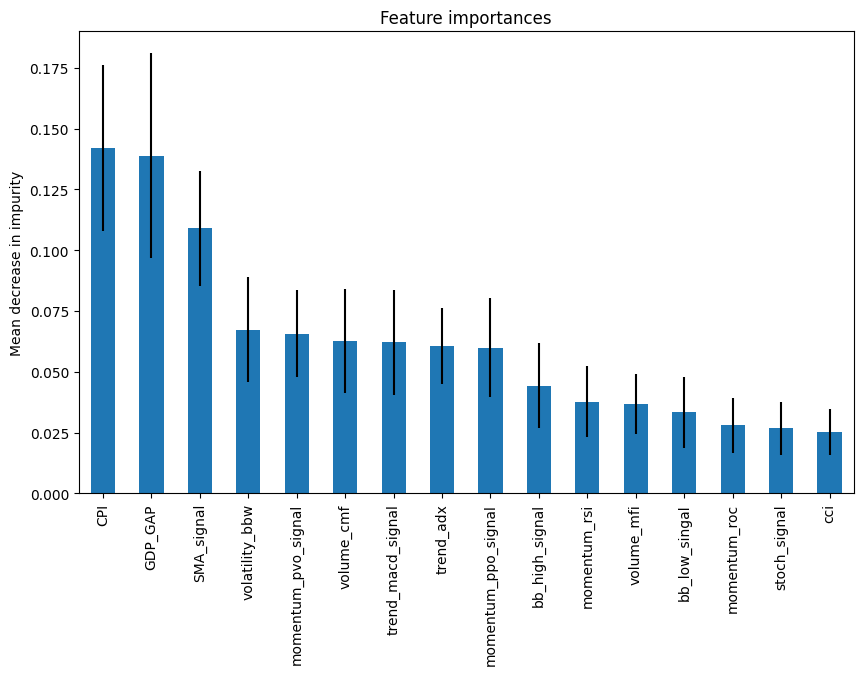

In [ ]:
# 1. 데이터 수집
data = yf.download(ticker, start=start_date, end=end_date, actions=True)
data['Adj Close'] = data['Adj Close'] + data['Dividends'].cumsum()

# 2. 기술적 지표 추가
data = add_ta(data)
data = add_macro_var (data, start_date, end_date)

data_org = data.copy()

# 3. 향후 1개월 후의 수익률 계산 및 라벨링
data['Future Return'] = data['Adj Close'].shift(-Wnd*3) / data['Adj Close'] - 1
data['Target'] = np.where(data['Future Return'] > Threshold, 1, np.where(data['Future Return'] < -Threshold, -1, 0))
data.dropna(inplace=True)

# 피쳐 리스트 생성
features = data.columns.difference(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Dividends', 'Stock Splits', 'Capital Gains', 'Future Return', 'Target'])

# 모델 학습 및 피쳐 중요도 계산
X, y = data[features], data['Target']
clf = RandomForestClassifier(n_estimators=100).fit(X, y)
feature_scores = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)

# 중요도 상위 N개 피쳐 출력
selected_features = [features[i] for i in clf.feature_importances_.argsort()[::-1][:10]]
for feature in selected_features:
    print(f"{feature}: {clf.feature_importances_[features.get_loc(feature)]}")

# 피쳐 중요도 그래프 출력
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
index_order = [list(features).index(feature) for feature in feature_scores.index]
sorted_std = std[index_order]

fig, ax = plt.subplots(figsize=(10, 6))
feature_scores.plot.bar(yerr=sorted_std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
plt.show()

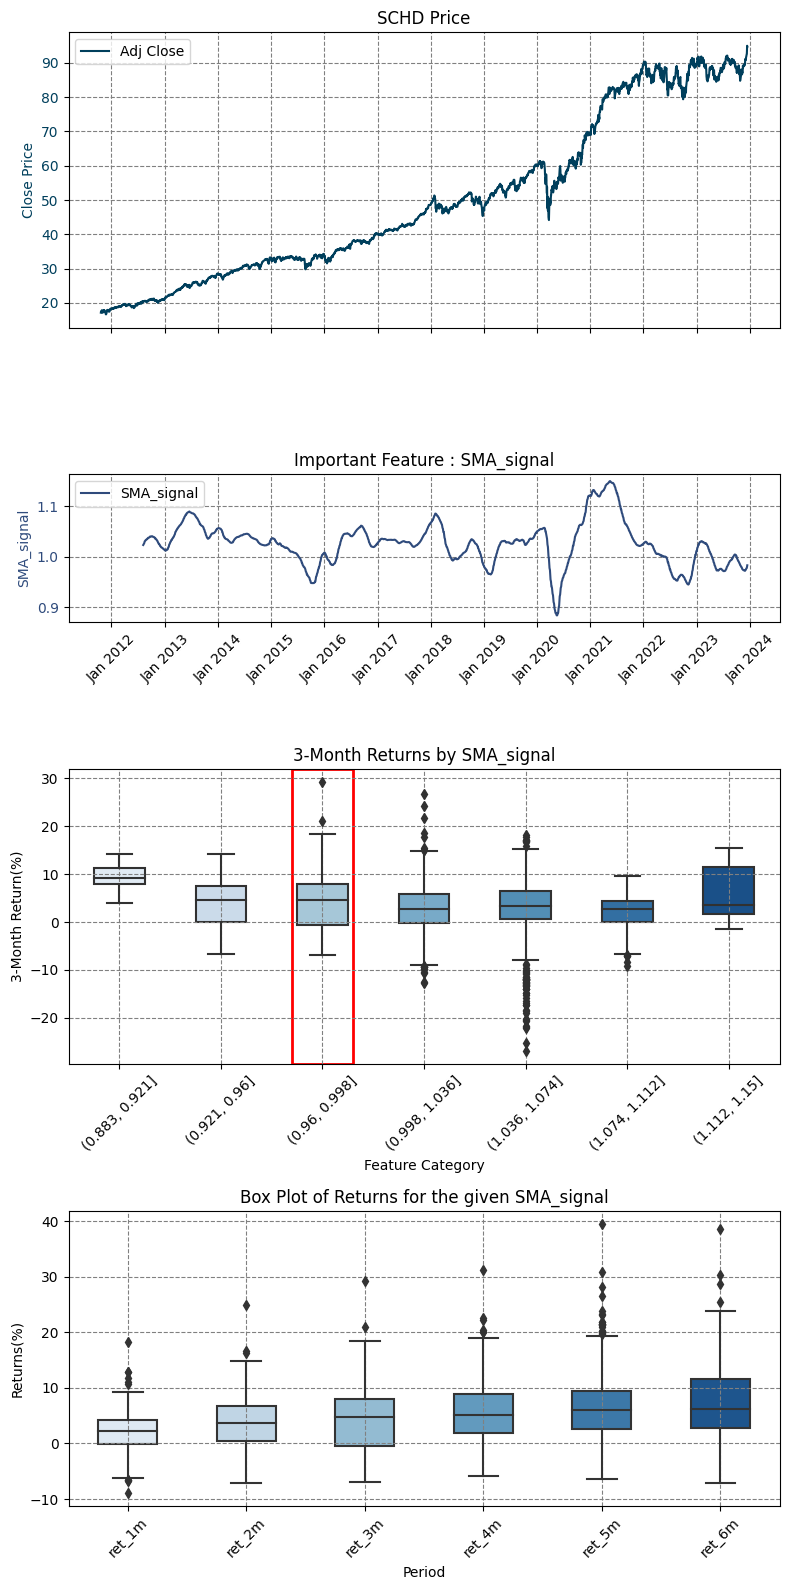

In [ ]:
"""
# Ensure that 'data_org' and 'selected_features' are properly initialized

# Append 'Adj Close' to 'selected_features' if not present
if 'Adj Close' not in selected_features:
    selected_features.append('Adj Close')
"""
# Assuming 'data_org' is a DataFrame and 'feature' is defined
feature = selected_features[2]

# Calculate returns
data_org['ret_1m'] = data_org['Adj Close'].pct_change(21).shift(-21) * 100
data_org['ret_2m'] = data_org['Adj Close'].pct_change(21*2).shift(-21*2) * 100
data_org['ret_3m'] = data_org['Adj Close'].pct_change(21*3).shift(-21*3) * 100
data_org['ret_4m'] = data_org['Adj Close'].pct_change(21*4).shift(-21*4) * 100
data_org['ret_5m'] = data_org['Adj Close'].pct_change(21*5).shift(-21*5) * 100
data_org['ret_6m'] = data_org['Adj Close'].pct_change(21*6).shift(-21*6) * 100

# Divide the feature into 10 equal-width intervals
data_org['feature_category'] = pd.cut(data_org[feature], bins=7)

# Filter data for the latest date
latest_date = data_org.index.max()  # Ensure your index is a datetime
latest_feature_category = data_org.loc[data_org.index == latest_date, 'feature_category'].iloc[0]
filtered_data = data_org[data_org['feature_category'] == latest_feature_category]

# Define traditional financial colors
dark_blue = '#003f5c'
forest_green = '#2f4b7c'

# Create a figure to hold all subplots
fig = plt.figure(figsize=(8, 16))

# Creating two subplots for 'Adj Close' and 'Feature'
gs = fig.add_gridspec(4, 1, height_ratios=[2, 1, 2, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)

# Plotting 'Adj Close'
ax1.plot(data_org.index, data_org['Adj Close'], color=dark_blue, label='Adj Close')
ax1.set_title(f'{ticker} Price')
ax1.set_ylabel('Close Price', color=dark_blue)
ax1.tick_params(axis='y', labelcolor=dark_blue)
ax1.legend(loc='upper left')
ax1.grid(True, linestyle='--', color='grey')

# Plotting 'Feature'
ax2.plot(data_org.index, data_org[feature], color=forest_green, label=feature)
ax2.set_title(f'Important Feature : {feature}')
ax2.set_ylabel(feature, color=forest_green)
ax2.tick_params(axis='y', labelcolor=forest_green)
ax2.tick_params(axis='x', rotation=45)
ax2.legend(loc='upper left')
ax2.grid(True, linestyle='--', color='grey')

# Formatting the x-axis with intervals
ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1]))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax1.get_xticklabels(), visible=False)  # Hide x-axis labels for ax1

# Box Plot for Different Period Returns
ax3 = fig.add_subplot(gs[2, 0])
sns.boxplot(x='feature_category', y='ret_3m', data=data_org, palette='Blues', ax=ax3, width = 0.5)
ax3.set_title(f'3-Month Returns by {feature}')
ax3.set_ylabel('3-Month Return(%)')
ax3.set_xlabel('Feature Category')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, linestyle='--', color='grey')

# Identify the position of the box for the specific feature
unique_features = sorted(data_org['feature_category'].unique().astype(str))
feature_pos = unique_features.index(str(latest_feature_category))

#feature_pos = data_org['feature_category'].unique().tolist().index(latest_feature_category)


# Draw a rectangle around the specific feature's box
# Adjust the width and height to fit your box plot
rect = patches.Rectangle((feature_pos - 0.3, ax3.get_ylim()[0]), 0.6, ax3.get_ylim()[1] - ax3.get_ylim()[0], linewidth=2, edgecolor='red', facecolor='none')
ax3.add_patch(rect)

# Box Plot for Different Period Returns
ax4 = fig.add_subplot(gs[3, 0])
sns.boxplot(data=filtered_data[['ret_1m', 'ret_2m', 'ret_3m', 'ret_4m', 'ret_5m', 'ret_6m']], palette='Blues', ax=ax4, width = 0.5)
ax4.set_title(f'Box Plot of Returns for the given {feature}')
ax4.set_ylabel('Returns(%)')
ax4.set_xlabel('Period')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, linestyle='--', color='grey')

# Adjust the spacing between ax1 and ax2
fig.tight_layout()
plt.show()

#3. 설명력이 높은 중요한 지표들만을 선택하여 Logistic Regression, Random Forest, Neutral Network를 이용, 향후 상승/하락 가능성을 추청

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import pickle
import joblib

"""from sklearn.externals import joblib

# 모델을 저장
joblib.dump(model, '모델_이름.pkl')

# 모델을 불러오기
loaded_model = joblib.load('모델_이름.pkl')
"""

class StockPredictionModel:

    def __init__(self, train_tickers, start_date, end_date, selected_features, wnd=21):
      self.train_tickers = train_tickers
      self.start_date = start_date
      self.end_date = end_date
      self.selected_features = selected_features
      self.wnd = wnd

      self.train_data = self.combine_data_from_multiple_tickers(train_tickers)

      self.X_train, self.y_train = self.prepare_data(self.train_data)
      self.lr = self.rf = self.nn = None

    def combine_data_from_multiple_tickers(self, tickers):
        combined_data = []
        for ticker in tickers:
            data = self.get_data_for_ticker(ticker)

            try:
            #if len(data) > 0:
              data = self.add_technical_indicators(data)
              combined_data.append(data)
            except:
              pass

        return pd.concat(combined_data)

    def get_data_for_ticker(self, ticker):
        return yf.download(ticker, start=self.start_date, end=self.end_date)

    def add_technical_indicators(self, data):
        # 기술적 분석 지표를 데이터에 추가
        data = add_ta(data)
        data = add_macro_var (data, self.start_date, self.end_date)
        data['ret'] = data['Adj Close'].shift(-1) / data['Adj Close'] - 1
        return data

    def prepare_data(self, data):
        Threshold = 0.05
        data.dropna(inplace=True)

        data['Future Return'] = data['Close'].shift(-self.wnd) / data['Close'] - 1
        data['Target'] = np.where(data['Future Return'] > Threshold, 2, np.where(data['Future Return'] > -Threshold, 1, 0))

        data.dropna(inplace=True)

        X = data[self.selected_features]
        y = data['Target']
        return X, y

    def logistic_regression(self):
        model_LR = LogisticRegression(multi_class='multinomial', fit_intercept=False, solver="lbfgs", max_iter=5000)
        model_LR.fit(self.X_train, self.y_train)
        y_pred = model_LR.predict(self.X_train)
        print("Logistic Regression Accuracy:", accuracy_score(self.y_train, y_pred))
        self.lr = model_LR

        joblib.dump(model_LR, 'model_LR.pkl')

    def random_forest(self):
        model_RF = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, oob_score=True)
        model_RF.fit(self.X_train, self.y_train)
        y_pred = model_RF.predict(self.X_train)
        print("Random Forest Accuracy:", accuracy_score(self.y_train, y_pred))
        self.rf = model_RF

    def neural_network(self):
        y_train_encoded = tf.keras.utils.to_categorical(self.y_train, num_classes=3)

        model_nn = keras.Sequential([
            layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(self.X_train.shape[1],)),
            layers.Dropout(0.5),
            layers.Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
            layers.Dropout(0.5),
            layers.Dense(3, activation='softmax')
        ])

        early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        model_nn.fit(self.X_train, y_train_encoded, epochs=500, batch_size=32, validation_split=0.2, verbose=0, callbacks=[early_stopping])

        test_loss, test_accuracy = model_nn.evaluate(self.X_train, y_train_encoded)
        print("Neural Network Accuracy:", test_accuracy)

        self.nn = model_nn

    def check_data_performance(self, model_name, data):
      # This function checks the performance using the given probabilities (either from LR, RF or NN).
      # Logic can be added here to check the performance.

      X = data[self.selected_features]

      if model_name == "lr":
        model = self.lr
        proba = model.predict_proba (X)

      elif model_name == "rf":
        model = self.lr
        proba = model.predict_proba (X)

      elif model_name == "nn":
        model = self.nn
        proba = model.predict (X)
      else:
        return None

      data['prob_down'] = proba[:, 0]
      data['prob_range'] = proba[:, 1]
      data['prob_up'] = proba[:, 2]
      data['upside'] = data['prob_up'] - data['prob_down']

      return data


#4. 예상 시나리오 출력

In [ ]:
!pip install -q pykrx
from pykrx import stock

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.1/247.1 kB 5.6 MB/s eta 0:00:00


In [ ]:
df = stock.get_market_fundamental("20100101", "20231231", "005930", freq="m")

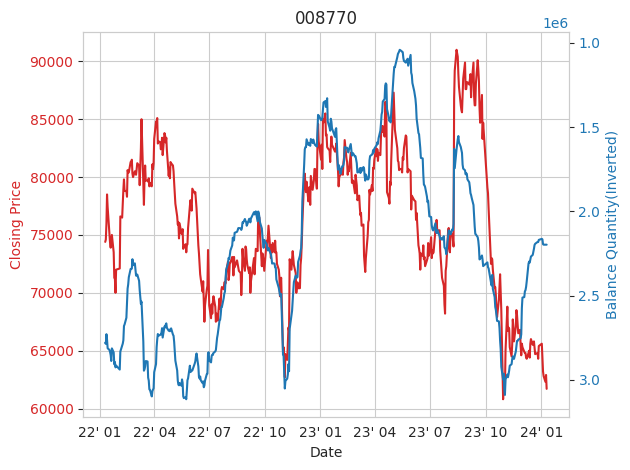

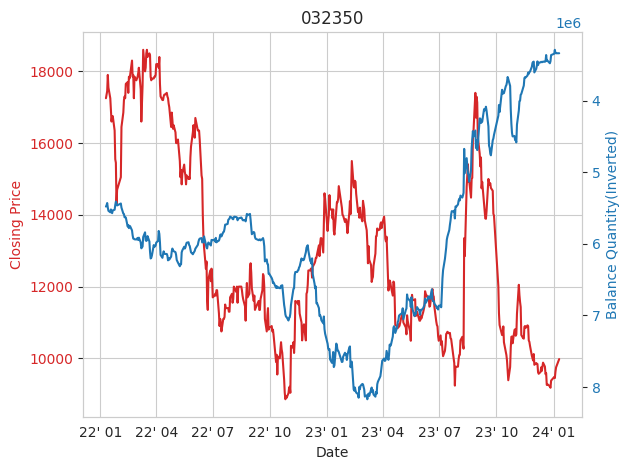

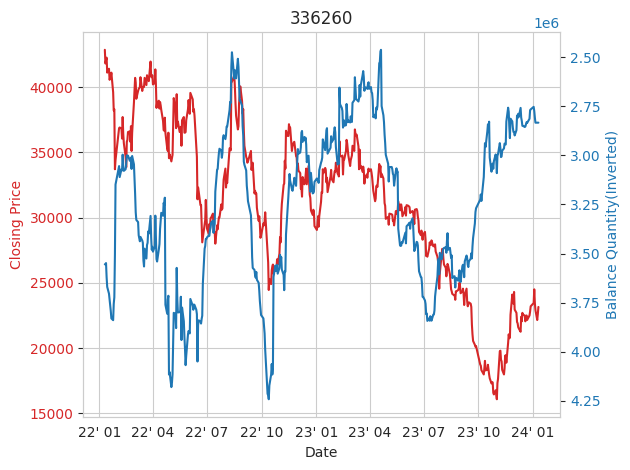

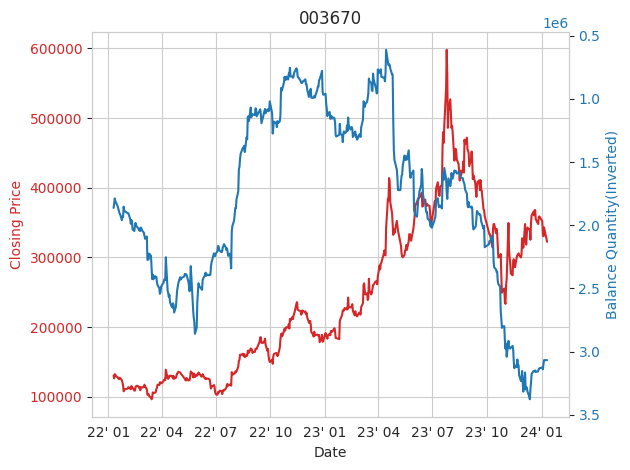

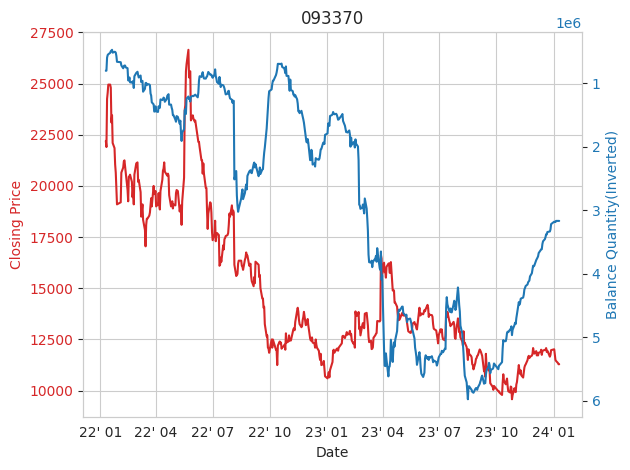

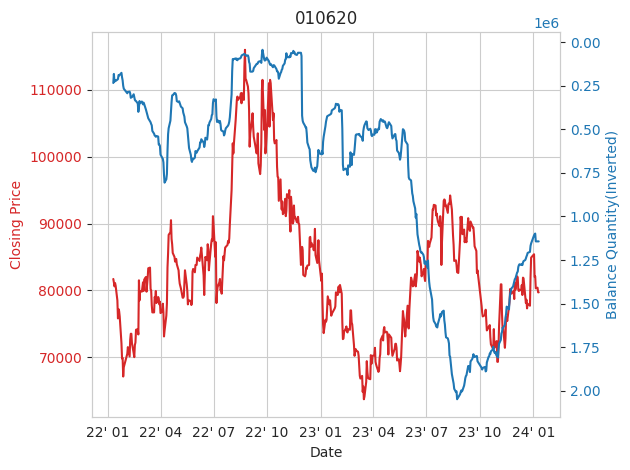

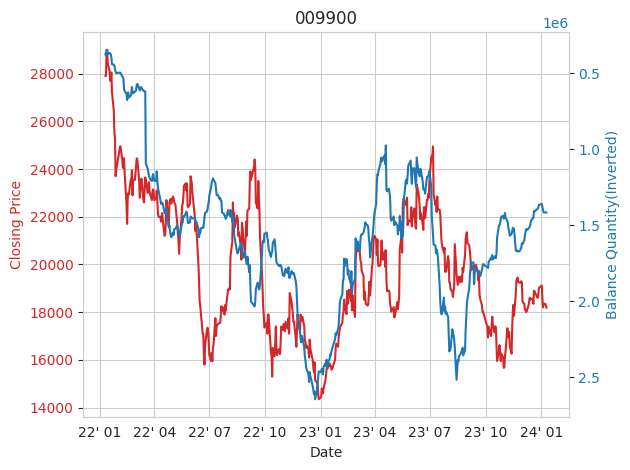

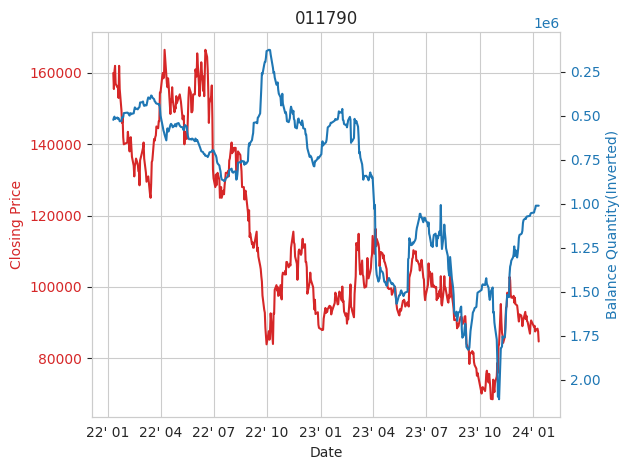

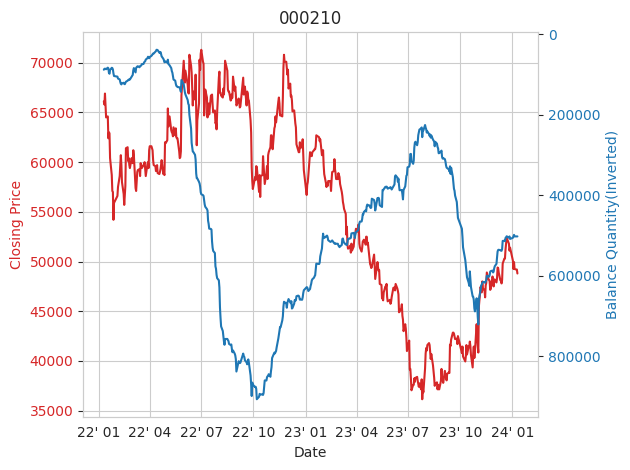

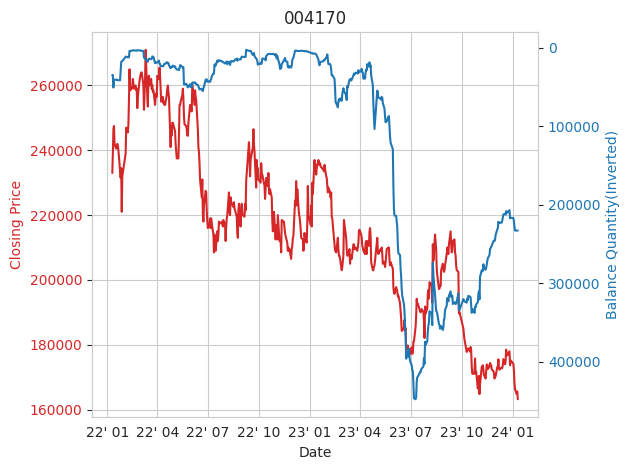

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

def get_shorting_balance_top50_last_available():
    today = datetime.now()
    attempts = 0

    while attempts < 10:  # 최대 10일 전까지 확인
        date_str = today.strftime("%Y%m%d")
        df = stock.get_shorting_balance_top50(date_str)

        if not df.empty:  # 데이터가 있는 경우
            return df
        else:  # 데이터가 없는 경우, 하루 전으로 날짜 조정
            today -= timedelta(days=1)
            attempts += 1

    print("지난 10일 동안 데이터가 없습니다.")

shortSell = get_shorting_balance_top50_last_available()

start_date = (datetime.now()-timedelta(days=365*2)).strftime("%Y%m%d")
end_date = datetime.now().strftime("%Y%m%d")

for ticker in shortSell.index[:10]:

    ss_price = stock.get_market_ohlcv(start_date, end_date, ticker)
    ss_position = stock.get_shorting_status_by_date(start_date, end_date, ticker)

    if len(ss_position) > 0:
        if ss_position['잔고수량'].iloc[-1] == 0:
            ss_position = ss_position[:-1]

        ss_composite = pd.concat([ss_price, ss_position], axis=1)
        ss_composite.fillna(method='ffill',inplace=True)

        #-------------------------------------------------------------------------------
        # 차트 스타일 설정
        # Seaborn 스타일 설정
        sns.set_style('whitegrid')

        fig, ax1 = plt.subplots()

        plt.title (f"{ticker}")
        # 첫 번째 y축 (종가) 설정
        color = 'tab:red'
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Closing Price', color=color)
        ax1.plot(ss_composite['종가'], color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        # 두 번째 y축 (잔고수량, 역축) 설정
        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('Balance Quantity(Inverted)', color=color)
        ax2.plot(ss_composite['잔고수량'], color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.invert_yaxis()
        ax2.grid(False)  # 두 번째 y축의 격자 비활성화

        # X축 레이블 설정 - 분기별
        ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter("%y' %m"))
        plt.xticks(rotation=45)  # X축 레이블을 45도 기울임

        fig.tight_layout()
        plt.show()